# 호출

In [35]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False
import matplotlib.pyplot as plt
import seaborn as sns

# 안정성 비율 확인

In [2]:
# 파일 경로
general_path = r"C:\Users\m\Desktop\변수 생성용 데이터\일반변수_안정성추가.csv"
sales_path = r"C:\Users\m\Desktop\변수 생성용 데이터\매출변수_안정성추가.csv"

# 데이터 불러오기
df_general = pd.read_csv(general_path)
df_sales = pd.read_csv(sales_path)

# 안정성 컬럼 값의 비율 계산 함수
def calculate_ratio(df, column_name="안정성"):
    value_counts = df[column_name].value_counts(normalize=True) * 100  # 비율(%)
    return value_counts

# 안정성 비율 계산
general_stability_ratio = calculate_ratio(df_general)
sales_stability_ratio = calculate_ratio(df_sales)

# 출력
print("일반 변수 데이터 안정성 비율:")
print(general_stability_ratio)
print("\n매출 변수 데이터 안정성 비율:")
print(sales_stability_ratio)

일반 변수 데이터 안정성 비율:
안정성
불안정    65.495189
안정     34.504811
Name: proportion, dtype: float64

매출 변수 데이터 안정성 비율:
안정성
불안정    65.822478
안정     34.177522
Name: proportion, dtype: float64


# 변수 추가

## 매출 파일 변수 추가

In [9]:
sales_path = r"C:\Users\m\Desktop\변수 생성용 데이터\매출변수_안정성추가.csv"

# CP949로 시도
try:
    df_sales = pd.read_csv(sales_path, encoding="cp949")
except UnicodeDecodeError:
    # EUC-KR로 다시 시도
    df_sales = pd.read_csv(sales_path, encoding="euc-kr")

print(df_sales.head())

     연분기            상권명  점포_수  개업_점포_수  폐업_점포_수  프랜차이즈_점포_수         매출_금액  \
0  20191   4.19민주묘지역 2번    29        0        1           5  2.712070e+08   
1  20191           63빌딩    64        1        2           6  1.993332e+08   
2  20191  DMC(디지털미디어시티)   450       32       37         150  3.050783e+09   
3  20191      GS강동자이아파트    88        6        5          13  5.969977e+08   
4  20191            G타워    18        1        0           8  2.236545e+08   

           매출_건수  자치구명  영업_개월_평균  ...  1년생존률  1년차창업기업수  1년생존기업수  3년생존률  \
0   19354.725490   강북구        93  ...     80        20       16   22.2   
1    7275.932785  영등포구        93  ...   88.2        34       30   65.6   
2  158335.952700   마포구        93  ...   71.3       174      124   44.0   
3   39455.145420   강동구        93  ...     75        32       24   40.9   
4   30836.642860   구로구        93  ...   78.9        19       15   69.2   

   3년차창업기업수  3년생존기업수  5년생존률  5년차창업기업수  5년생존기업수  안정성  
0        18        4     36        25 

In [24]:
import pandas as pd
import chardet

# 파일 경로
sales_path = r"C:\Users\m\Desktop\변수 생성용 데이터\매출변수_안정성추가.csv"
output_path = r"C:\Users\m\Desktop\변수 생성용 데이터\매출변수.csv"

# 인코딩 자동 감지
with open(sales_path, "rb") as f:
    result = chardet.detect(f.read(100000))  # 일부 데이터 샘플링
    encoding_type = result["encoding"]

# 데이터 불러오기
try:
    df_sales = pd.read_csv(sales_path, encoding="utf-8")
except UnicodeDecodeError:
    try:
        df_sales = pd.read_csv(sales_path, encoding="utf-8-sig")
    except UnicodeDecodeError:
        df_sales = pd.read_csv(sales_path, encoding="cp949")

# 연분기를 기준으로 정렬
df_sales = df_sales.sort_values(["상권명", "연분기"])

# 4개 분기 기준 rolling 함수 적용
def rolling_std(series):
    return series.rolling(window=4, min_periods=1).std()

# 새로운 변수 생성
df_sales["점포_수_변동성"] = df_sales.groupby("상권명")["점포_수"].transform(rolling_std)
df_sales["프랜차이즈_변동성"] = df_sales.groupby("상권명")["프랜차이즈_점포_수"].transform(rolling_std)

# 점포 증감률 계산 (이전 분기 대비)
df_sales["이전_분기_점포_수"] = df_sales.groupby("상권명")["점포_수"].shift(1)
df_sales["점포_증감률"] = (df_sales["점포_수"] - df_sales["이전_분기_점포_수"]) / df_sales["이전_분기_점포_수"] * 100
df_sales["점포_변동량"] = df_sales["점포_수"] - df_sales["이전_분기_점포_수"]

# 개폐업 균형 지수 계산
df_sales["개폐업_균형_지수"] = (df_sales["개업_점포_수"] - df_sales["폐업_점포_수"]) / (df_sales["개업_점포_수"] + df_sales["폐업_점포_수"] + 1) * 100

# 점포 생존율 계산
df_sales["점포_생존율"] = 1 - (df_sales["폐업_점포_수"] / df_sales["점포_수"])

# 매출 변동성 (4개 분기 기준)
df_sales["매출_금액_변동성"] = df_sales.groupby("상권명")["매출_금액"].transform(rolling_std)
df_sales["매출_건수_변동성"] = df_sales.groupby("상권명")["매출_건수"].transform(rolling_std)

# 불필요한 컬럼 삭제 (이전 분기 점포 수)
df_sales.drop(columns=["이전_분기_점포_수"], inplace=True)

# 파일 저장 (utf-8-sig 인코딩 지정)
df_sales.to_csv(output_path, index=False, encoding="utf-8-sig")

print(f"파일이 저장되었습니다: {output_path}")

파일이 저장되었습니다: C:\Users\m\Desktop\변수 생성용 데이터\매출변수.csv


## 일반 파일 변수 추가

In [25]:
import pandas as pd
import chardet

# 파일 경로
sales_path = r"C:\Users\m\Desktop\변수 생성용 데이터\일반변수_안정성추가.csv"
output_path = r"C:\Users\m\Desktop\변수 생성용 데이터\일반변수.csv"

# 인코딩 자동 감지
with open(sales_path, "rb") as f:
    result = chardet.detect(f.read(100000))  # 일부 데이터 샘플링
    encoding_type = result["encoding"]

# 데이터 불러오기
try:
    df_sales = pd.read_csv(sales_path, encoding="utf-8")
except UnicodeDecodeError:
    try:
        df_sales = pd.read_csv(sales_path, encoding="utf-8-sig")
    except UnicodeDecodeError:
        df_sales = pd.read_csv(sales_path, encoding="cp949")

# 연분기를 기준으로 정렬
df_sales = df_sales.sort_values(["상권명", "연분기"])

# 4개 분기 기준 rolling 함수 적용
def rolling_std(series):
    return series.rolling(window=4, min_periods=1).std()

# 새로운 변수 생성
df_sales["점포_수_변동성"] = df_sales.groupby("상권명")["점포_수"].transform(rolling_std)
df_sales["프랜차이즈_변동성"] = df_sales.groupby("상권명")["프랜차이즈_점포_수"].transform(rolling_std)

# 점포 증감률 계산 (이전 분기 대비)
df_sales["이전_분기_점포_수"] = df_sales.groupby("상권명")["점포_수"].shift(1)
df_sales["점포_증감률"] = (df_sales["점포_수"] - df_sales["이전_분기_점포_수"]) / df_sales["이전_분기_점포_수"] * 100
df_sales["점포_변동량"] = df_sales["점포_수"] - df_sales["이전_분기_점포_수"]

# 개폐업 균형 지수 계산
df_sales["개폐업_균형_지수"] = (df_sales["개업_점포_수"] - df_sales["폐업_점포_수"]) / (df_sales["개업_점포_수"] + df_sales["폐업_점포_수"] + 1) * 100

# 점포 생존율 계산
df_sales["점포_생존율"] = 1 - (df_sales["폐업_점포_수"] / df_sales["점포_수"])

# 불필요한 컬럼 삭제 (이전 분기 점포 수)
df_sales.drop(columns=["이전_분기_점포_수"], inplace=True)

# 파일 저장 (utf-8-sig 인코딩 지정)
df_sales.to_csv(output_path, index=False, encoding="utf-8-sig")

print(f"파일이 저장되었습니다: {output_path}")

파일이 저장되었습니다: C:\Users\m\Desktop\변수 생성용 데이터\일반변수.csv


# 상관관계 분석

In [28]:
import pandas as pd

# 데이터 로드
file_path = r"C:\Users\m\Desktop\변수 생성용 데이터\매출변수_20192.csv"
df = pd.read_csv(file_path, encoding="utf-8")

# 안정성 컬럼을 1(안정) / 0(불안정)으로 변환
df["안정성(수치형)"] = df["안정성"].map({"안정": 1, "불안정": 0})

# 상관계수 계산 대상 컬럼 리스트
target_columns = [
    "점포_수_변동성", "점포_변동량", "점포_증감률", "프랜차이즈_변동성",
    "개폐업_균형_지수", "매출_금액_변동성", "매출_건수_변동성", "1년생존률", "5년생존률"
]

# 숫자로 변환 (문자값 '-' 등을 NaN으로 변환)
df[target_columns] = df[target_columns].apply(pd.to_numeric, errors="coerce")

# NaN 확인 및 처리
print(df[target_columns].isna().sum())  # NaN 개수 확인
df.fillna(0, inplace=True)  # NaN을 0으로 대체

# 안정성과 각 변수의 상관계수 계산
correlation_results = df[target_columns].corrwith(df["안정성(수치형)"])

# 출력
print(correlation_results)

점포_수_변동성      27
점포_변동량        27
점포_증감률        53
프랜차이즈_변동성     27
개폐업_균형_지수      0
매출_금액_변동성     27
매출_건수_변동성     27
1년생존률        176
5년생존률        103
dtype: int64
점포_수_변동성     0.010516
점포_변동량      -0.018428
점포_증감률            NaN
프랜차이즈_변동성   -0.086391
개폐업_균형_지수    0.000890
매출_금액_변동성   -0.013418
매출_건수_변동성   -0.027515
1년생존률        0.102261
5년생존률        0.186578
dtype: float64


c:\Users\m\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


## null 포함 행 제거

In [29]:
import numpy as np

# 안정성 컬럼을 숫자로 변환 (안정: 1, 불안정: 0)
df["안정성(수치형)"] = df["안정성"].map({"안정": 1, "불안정": 0})

# inf와 NaN 값 제거
df_filtered = df.replace([np.inf, -np.inf], np.nan).dropna()

# 상관계수 계산할 컬럼 목록
target_columns = [
    "안정성(수치형)", "점포_수_변동성", "점포_변동량", "점포_증감률", "프랜차이즈_변동성",
    "개폐업_균형_지수", "매출_금액_변동성", "매출_건수_변동성", "1년생존률", "5년생존률"
]

# 상관계수 행렬 계산
correlation_matrix = df_filtered[target_columns].corr()

# 출력
print(correlation_matrix)

           안정성(수치형)  점포_수_변동성    점포_변동량    점포_증감률  프랜차이즈_변동성  개폐업_균형_지수  \
안정성(수치형)   1.000000  0.010569 -0.018448  0.020516  -0.086291   0.000650   
점포_수_변동성   0.010569  1.000000 -0.056321  0.041183   0.400663  -0.003121   
점포_변동량    -0.018448 -0.056321  1.000000  0.267431   0.016181   0.193269   
점포_증감률     0.020516  0.041183  0.267431  1.000000  -0.009269   0.164166   
프랜차이즈_변동성 -0.086291  0.400663  0.016181 -0.009269   1.000000   0.007954   
개폐업_균형_지수  0.000650 -0.003121  0.193269  0.164166   0.007954   1.000000   
매출_금액_변동성 -0.013353  0.179526  0.005789 -0.016202   0.236497  -0.005640   
매출_건수_변동성 -0.027533  0.112988  0.014901 -0.012531   0.223436   0.012737   
1년생존률      0.102152  0.027403  0.006065  0.020602   0.003083   0.041831   
5년생존률      0.186650  0.060404 -0.009031  0.013664  -0.031912  -0.001096   

           매출_금액_변동성  매출_건수_변동성     1년생존률     5년생존률  
안정성(수치형)   -0.013353  -0.027533  0.102152  0.186650  
점포_수_변동성    0.179526   0.112988  0.027403  0.060404  
점포_변동량      

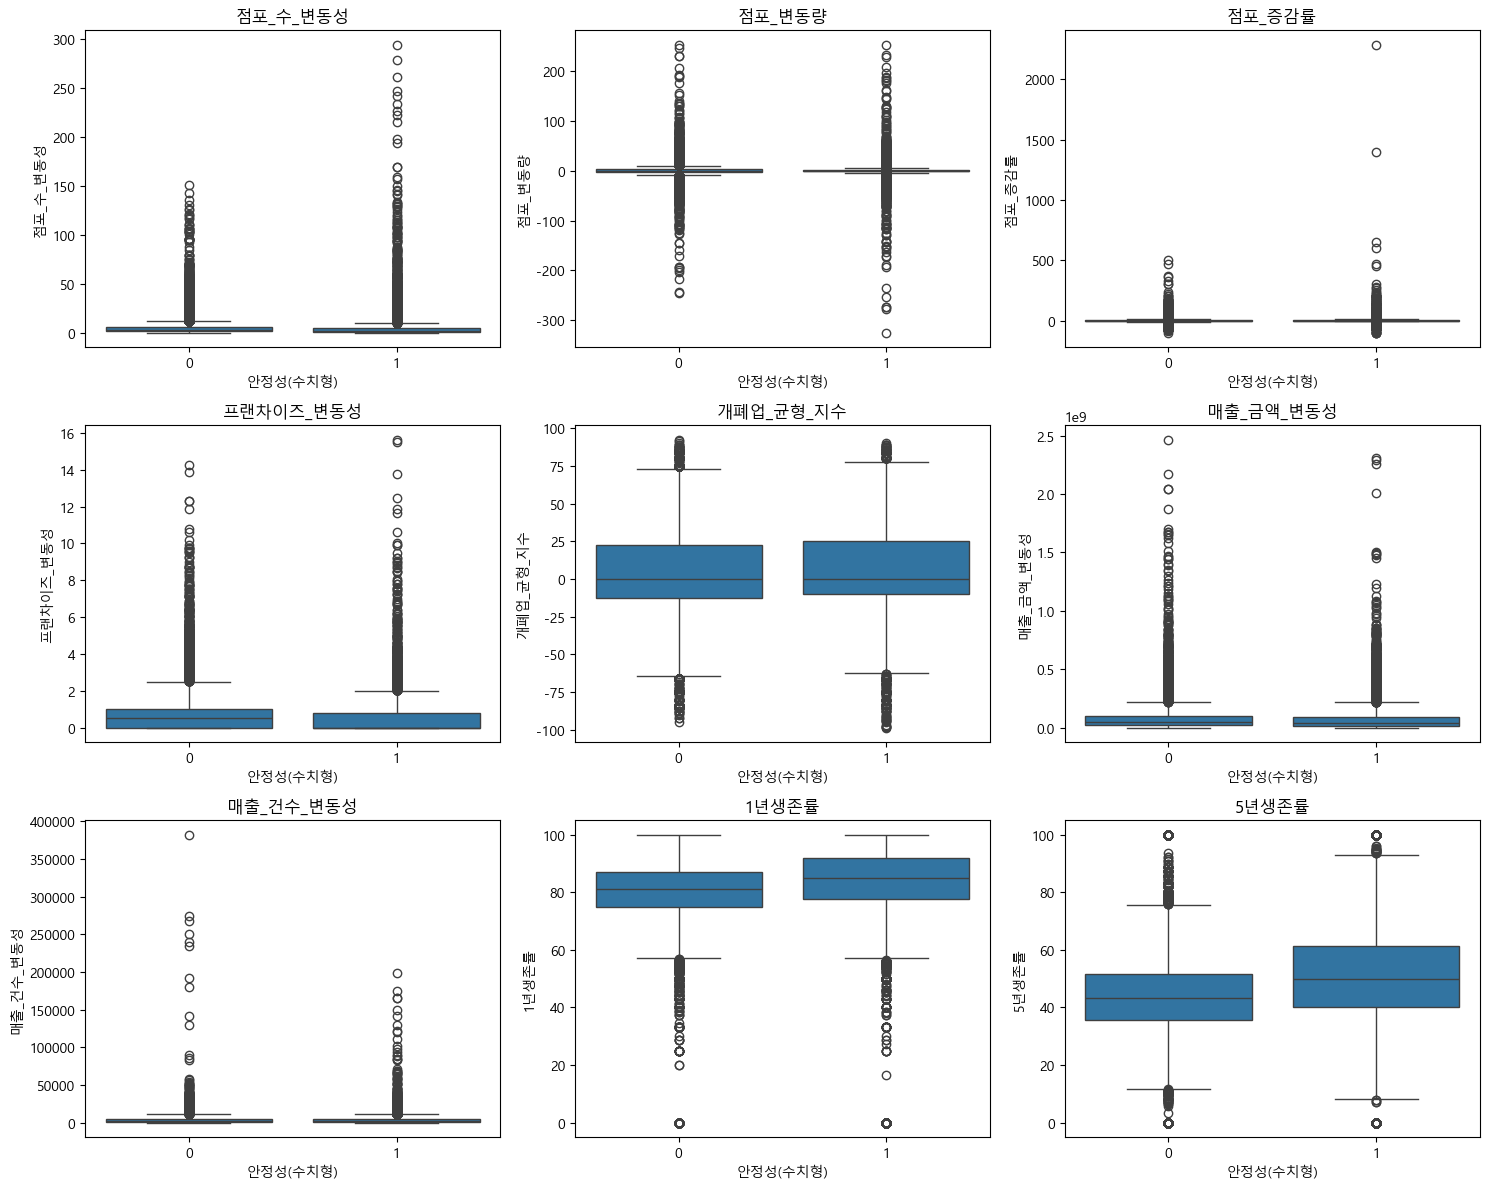

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# inf와 NaN 값 처리
df_filtered = df.replace([np.inf, -np.inf], np.nan).dropna()

# 안정성 컬럼을 숫자로 변환 (안정=1, 불안정=0)
df_filtered["안정성(수치형)"] = df_filtered["안정성"].map({"안정": 1, "불안정": 0})

# 비교할 변수 목록
variables = ["점포_수_변동성", "점포_변동량", "점포_증감률", "프랜차이즈_변동성",
             "개폐업_균형_지수", "매출_금액_변동성", "매출_건수_변동성", "1년생존률", "5년생존률"]

# 그래프 크기 설정
plt.figure(figsize=(15, 12))

# 변수별 박스플롯 출력
for i, var in enumerate(variables, 1):
    plt.subplot(3, 3, i)  # 3x3 그리드로 그래프 배치
    sns.boxplot(x="안정성(수치형)", y=var, data=df_filtered)
    plt.title(var)

plt.tight_layout()  # 그래프 간격 자동 조절
plt.show()

# PCA

In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.decomposition import PCA

# 파일 경로
file_path = r"C:\Users\m\Desktop\변수 생성용 데이터\매출변수_20192.csv"

# 데이터 불러오기
df = pd.read_csv(file_path, encoding="utf-8")

# 2024년 2분기 데이터 필터링
df = df[df['연분기'] == 20242]

# 사용할 특성(변수) 목록
features = ['프랜차이즈_변동성', '개폐업_균형_지수', '3년생존률', '매출_금액_변동성']
df_selected = df[['상권명'] + features]

# 상권별 평균값 계산
df_selected = df_selected.groupby('상권명')[features].mean().reset_index()

# 결측치(NaN) 처리: 중앙값으로 대체
df_selected[features] = df_selected[features].fillna(df_selected[features].median())

# 로그 변환 (음수 방지)
for feature in features:
    min_val = df_selected[feature].min()
    if min_val < 0:
        df_selected[feature] = df_selected[feature] - min_val + 1  # 최소값을 1로 조정
    df_selected[feature] = np.log1p(df_selected[feature])  # log(1 + x) 적용

# 정규화 (Z-score 변환)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_selected[features])

# 정규분포 변환 (QuantileTransformer)
qt = QuantileTransformer(output_distribution='normal', random_state=42)
normalized_features = qt.fit_transform(scaled_features)

# PCA 수행
pca = PCA(n_components=1)
pca_result = pca.fit_transform(normalized_features)

# 균일 분포 변환 후 0~20 스케일링
qt_uniform = QuantileTransformer(output_distribution='uniform', random_state=42)
final_scores = qt_uniform.fit_transform(pca_result) * 20

# 결과 데이터프레임 생성
result_df = pd.DataFrame({
    '상권명': df_selected['상권명'],
    '안정성_점수': final_scores.flatten()
})

# 안정성 점수 기준 내림차순 정렬
result_df = result_df.sort_values('안정성_점수', ascending=False)

# 출력
print(result_df)


          상권명     안정성_점수
525    목동신시가지  20.000000
171   구로디지털단지  19.980809
45        강남역  19.973299
1433      한티역  19.959976
291       노원역  19.948697
...       ...        ...
628      북정마을   0.057942
864    수색역 1번   0.040027
1282     조양시장   0.026352
237   길음역 10번   0.013314
1114   영진시장A동   0.000000

[1502 rows x 2 columns]


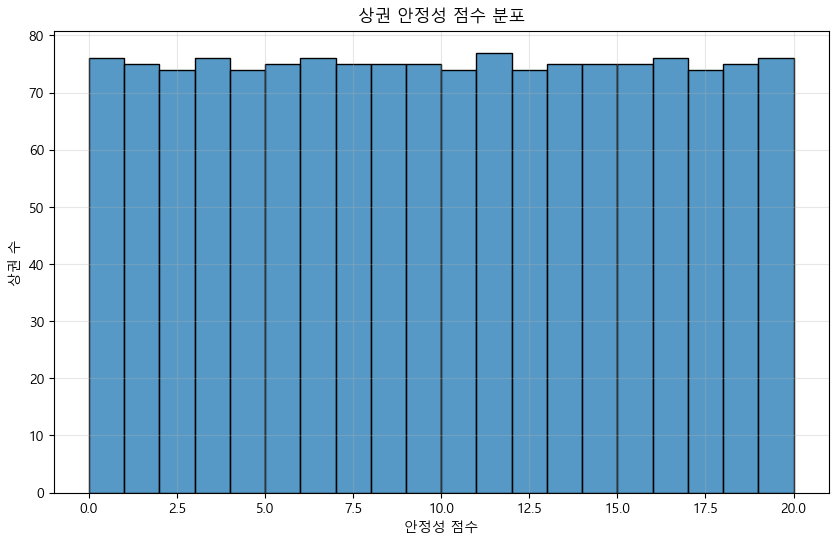

In [47]:
# 히스토그램 생성
plt.figure(figsize=(10, 6))
sns.histplot(data=result_df, x='안정성_점수', bins=20)

# 그래프 제목과 축 레이블 설정
plt.title('상권 안정성 점수 분포')
plt.xlabel('안정성 점수')
plt.ylabel('상권 수')

# 그리드 추가
plt.grid(True, alpha=0.3)

plt.show()